# Paper ST Sloping - 32 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_32beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,...,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807,-0.008983,NSR
1,e0106,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,...,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060,-0.004790,NSR
2,e0106,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,...,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271,-0.005162,NSR
3,e0106,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,...,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778,-0.000208,NSR
4,e0106,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,...,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157,-0.002940,NSR


In [5]:
data['label'].value_counts()

NSR    13090
ST-     2753
ST+     1229
Name: label, dtype: int64

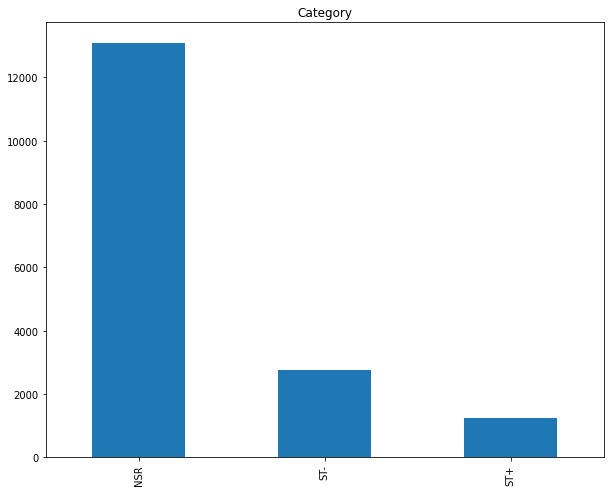

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.237685,0.106778,0.074513,0.049017,0.164754,-0.043134,0.066522,-0.005085,0.007374,...,-0.101746,-0.045780,-0.057627,-0.042941,-0.032342,-0.074357,-0.049488,-0.067248,-0.103371,-0.094220
dw_2,0.237685,1.000000,0.838142,0.502265,0.189472,0.396750,-0.511218,-0.362148,0.007304,0.027974,...,-0.110800,0.180227,0.237271,0.173162,0.054253,0.037079,0.134331,0.012952,-0.116243,-0.070422
dw_3,0.106778,0.838142,1.000000,0.702042,0.287089,0.241283,-0.555562,-0.499643,0.012774,0.016280,...,-0.199872,0.154880,0.275167,0.120954,-0.052022,0.066460,0.043879,-0.017784,-0.133008,-0.045069
dw_4,0.074513,0.502265,0.702042,1.000000,0.873295,-0.014716,-0.278260,-0.278962,0.008457,0.006416,...,-0.152384,0.071768,0.115122,0.067878,-0.039769,0.051749,0.026810,-0.031360,-0.111832,-0.044385
dw_5,0.049017,0.189472,0.287089,0.873295,1.000000,-0.124955,-0.026226,-0.049222,0.001954,0.000388,...,-0.063773,0.011881,-0.006932,0.044290,0.004779,0.016077,0.019832,-0.039655,-0.062702,-0.031614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.074357,0.037079,0.066460,0.051749,0.016077,-0.150115,0.112145,0.135231,-0.002228,0.004135,...,-0.135005,-0.212171,-0.056621,0.041745,0.071561,1.000000,0.024910,0.010580,-0.361983,-0.228896
cfr_13,-0.049488,0.134331,0.043879,0.026810,0.019832,0.073383,-0.006052,0.015178,0.006819,-0.001301,...,0.163738,0.044522,-0.209958,-0.266707,0.009957,0.024910,1.000000,0.238508,0.156749,-0.141656
cfr_14,-0.067248,0.012952,-0.017784,-0.031360,-0.039655,-0.001977,0.028472,0.029755,0.005549,-0.006743,...,0.121685,0.230485,0.039279,-0.173963,-0.282881,0.010580,0.238508,1.000000,0.221302,-0.128261
cfr_15,-0.103371,-0.116243,-0.133008,-0.111832,-0.062702,0.047377,0.081087,0.044183,0.001850,-0.014418,...,0.293341,0.157001,-0.089191,-0.138736,-0.062263,-0.361983,0.156749,0.221302,1.000000,0.344573


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_179', 'fft_186', 'fft_152', 'fft_145', 'fft_135', 'fft_247', 'fft_168', 'fft_230', 'fft_255', 'fft_234', 'fft_184', 'fft_188', 'fft_202', 'fft_240', 'mfw_12', 'fft_137', 'fft_149', 'fft_219', 'fft_201', 'fft_232', 'mfw_10', 'fft_134', 'fft_144', 'fft_218', 'mfw_13', 'fft_228', 'fft_173', 'fft_139', 'fft_178', 'fft_208', 'fft_204', 'fft_163', 'fft_193', 'mfw_16', 'fft_253', 'fft_150', 'fft_151', 'fft_183', 'fft_205', 'fft_155', 'fft_206', 'fft_214', 'fft_221', 'fft_175', 'fft_231', 'fft_180', 'fft_133', 'fft_198', 'fft_213', 'fft_153', 'mfw_8', 'fft_147', 'fft_190', 'fft_156', 'fft_239', 'cfr_16', 'fft_199', 'fft_212', 'fft_251', 'fft_238', 'fft_131', 'fft_143', 'fft_196', 'fft_224', 'fft_157', 'fft_159', 'fft_165', 'fft_176', 'fft_192', 'fft_203', 'fft_210', 'mfw_9', 'fft_138', 'fft_195', 'fft_200', 'fft_154', 'fft_252', 'fft_148', 'fft_222', 'fft_211', 'fft_233', 'fft_161', 'mfw_14', 'fft_226', 'fft_166', 'fft_171', 'fft_164', 'fft_197', 'fft_181', 'fft_254', 'mfw_6', 'fft_220',

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_19
fft_20
fft_21
fft_22
fft_24
fft_25
fft_26
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_11
ar_12
ar_13
ar_14
ar_15
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 74


### Visualization best features

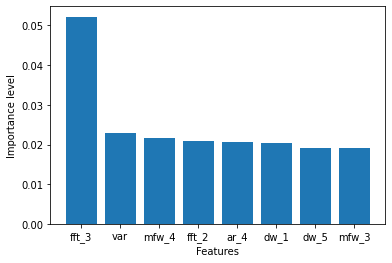

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,133.429003,134.242162,133.489322,37.853305,5.508392,0.586324,-0.522381,-0.788889,-0.136987,-1.009483,...,0.017932,0.038860,-0.042238,0.026644,-0.034630,0.040781,-0.065560,0.001347,-0.022417,-0.007807
1,133.965830,136.903950,136.743215,38.927755,5.696305,0.593533,-0.515953,-0.790798,-0.224475,2.486222,...,0.014723,0.042961,-0.052676,0.042240,-0.050718,0.057318,-0.078975,0.010010,-0.026053,-0.011060
2,139.274723,140.184030,140.070259,39.704137,5.761162,0.577124,-0.518431,-0.807961,-0.219536,-2.150671,...,0.006243,0.051369,-0.051818,0.032123,-0.034994,0.042277,-0.076328,0.011880,-0.026580,-0.008271
3,138.676856,143.380168,143.473350,40.663806,5.859970,0.588245,-0.513443,-0.810437,-0.247007,-4.289119,...,0.014157,0.055342,-0.057101,0.036792,-0.033449,0.035388,-0.067010,0.008826,-0.025932,-0.011778
4,140.755171,142.872499,143.424214,40.769824,5.919625,0.585157,-0.517127,-0.798512,-0.176490,-1.067047,...,0.034652,0.022510,-0.031786,0.019955,-0.031716,0.039832,-0.068147,0.004500,-0.023807,-0.012157


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, seed in enumerate(seeds):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=seed)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 2.935359239578247 s
Tot: Accuracy 0.9165446559297218 Precision 0.9164207884212858 Recall 0.9165446559297218 Specificity 0.7662270024957477 F1 0.9119113348788509
NSR: Accuracy 0.9165446559297218 Precision 0.9180851063829787 Recall 0.9795686719636776 Specificity 0.7007772020725389 F1 0.9478308621636463
ST+: Accuracy 0.9812591508052708 Precision 0.8935185185185185 Recall 0.8247863247863247 Specificity 0.9927695693178246 F1 0.8577777777777778
ST-: Accuracy 0.9812591508052708 precision 0.9182058047493403 Recall 0.6468401486988847 Specificity 0.989224887035106 F1 0.7589967284623773
#---------------------#
#---------------------#
2 of 1000 - 2.8992323875427246 s
Tot: Accuracy 0.91800878477306 Precision 0.9187274158776061 Recall 0.91800878477306 Specificity 0.769224810146719 F1 0.9136409729560927
NSR: Accuracy 0.91800878477306 Precision 0.9161634103019538 Recall 0.9832253145253527 Specificity 0.702020202020202 F1 0.9485104817947775
ST+: Accuracy 0.9786237188

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.916545,0.916421,0.916545,0.766227,0.911911,0.916545,0.918085,0.979569,0.700777,0.947831,0.981259,0.893519,0.824786,0.992770,0.857778,0.981259,0.918206,0.646840,0.989225,0.758997
1,0.918009,0.918727,0.918009,0.769225,0.913641,0.918009,0.916163,0.983225,0.702020,0.948510,0.978624,0.915000,0.765690,0.994647,0.833713,0.978624,0.932500,0.674503,0.990566,0.782791
2,0.910688,0.910617,0.910688,0.767659,0.905710,0.910981,0.911765,0.977692,0.698160,0.943578,0.979209,0.895397,0.823077,0.992076,0.857715,0.979209,0.912371,0.637838,0.988112,0.750795
3,0.913324,0.913965,0.913324,0.760569,0.908006,0.913616,0.912673,0.981298,0.690566,0.945742,0.980088,0.899563,0.820717,0.992731,0.858333,0.980088,0.926829,0.628676,0.990596,0.749179
4,0.913616,0.915623,0.913616,0.751849,0.908044,0.913909,0.908289,0.986968,0.677419,0.945996,0.981552,0.945355,0.765487,0.996864,0.845966,0.981552,0.937028,0.641379,0.991182,0.761515
5,0.913031,0.912430,0.913031,0.781983,0.908753,0.913616,0.916847,0.975010,0.717445,0.945034,0.978624,0.881890,0.838951,0.990470,0.859885,0.978624,0.906329,0.654479,0.987099,0.760085
6,0.915081,0.914988,0.915081,0.766332,0.910322,0.915373,0.914977,0.980931,0.698613,0.946807,0.980381,0.923077,0.803150,0.994622,0.858947,0.980381,0.911227,0.647495,0.988178,0.757050
7,0.913324,0.913234,0.913324,0.759931,0.908047,0.913909,0.914215,0.980236,0.691327,0.946075,0.981259,0.900901,0.826446,0.993066,0.862069,0.981259,0.913978,0.627306,0.988862,0.743982
8,0.910395,0.910825,0.910395,0.749918,0.904740,0.910395,0.910216,0.980206,0.677665,0.943915,0.979502,0.896396,0.808943,0.992742,0.850427,0.979502,0.920330,0.618081,0.989906,0.739514
9,0.918594,0.919089,0.918594,0.761077,0.913675,0.918594,0.917224,0.983755,0.694010,0.949326,0.980381,0.923423,0.803922,0.994620,0.859539,0.980381,0.926554,0.639376,0.991041,0.756632


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_32beats_1000x_random_split.csv')

######## Total ########
Accuracy 0.9150541727672032
Precision 0.9156507721488799
Recall 0.9150541727672032
Specificity 0.7656600754189306
F1 0.9101602204928727
######## NSR ########
Accuracy 0.9152266471449485
Precision 0.9141039469114155
Recall 0.981673202316999
Specificity 0.6970039578543583
F1 0.9466739824566409
######## ST+ ########
Accuracy 0.9802278184480232
Precision 0.908766920812212
Recall 0.8064915052677065
Specificity 0.9937144861590234
F1 0.8542874180349045
######## ST- ########
Accuracy 0.9802278184480232
Precision 0.9256586536009819
Recall 0.6471367525258523
Specificity 0.989995804172752
F1 0.761526544135079
